In [ ]:
import json
import re
import pandas as pd

import matplotlib as mpl
import palettable
from pymatgen.analysis.phase_diagram import (
    CompoundPhaseDiagram,
    PDPlotter,
    PhaseDiagram,
)
from pymatgen.core import Composition, Element
from pymatgen.entries.compatibility import MaterialsProjectCompatibility
from pymatgen.entries.computed_entries import ComputedEntry
from pymatgen.ext.matproj import MPRester
from pymatgen.io.vasp import Vasprun
from pymatgen.util.plotting import pretty_plot

In [ ]:
# 读取文件并初始化 MPRester
file_path = "../Data/9_APs_with_screened_K_G.csv"
api_key = "kTz31FPeiv31aeO6HguF8OotU8y8pGNR"  # 请确保安全使用 API Key
rester = MPRester(api_key)

# 读取包含化学式的文件
df = pd.read_csv(file_path)
compositions = df['composition'].tolist()

# 创建一个字典来存储每个化学式的结果
results = {}

# 对于每个化学式进行处理
for idx, comp_str in enumerate(compositions, start=1):
    print(f"Processing {idx}/{len(compositions)}: {comp_str}")
    comp = Composition(comp_str)
    element_symbols = [el.symbol for el in comp.elements]

    # 尝试获取化学系统条目
    try:
        mp_entries = rester.get_entries_in_chemsys(element_symbols)
    except Exception as e:
        print(f"Error retrieving entries for elements {element_symbols}: {e}")
        continue

    # 处理条目并构建相图
    compatibility = MaterialsProjectCompatibility()
    entries = compatibility.process_entries(mp_entries)

    # 查找碱金属条目
    alkali_elements = [el for el in comp.elements if el.symbol in ["Li", "Na", "K"]]
    if not alkali_elements:
        print(f"Skipping composition {comp_str} as it contains no alkali metals.")
        continue
    
    alkali = alkali_elements[0]
    alkali_entries = [e for e in entries if e.composition.reduced_formula == alkali.symbol]
    if not alkali_entries:
        print(f"No entries found for alkali metal {alkali.symbol} in composition {comp_str}.")
        continue
    
    u0 = min(alkali_entries, key=lambda e: e.energy_per_atom).energy_per_atom

    # 创建相图并获取元素剖面
    pd = PhaseDiagram(entries)
    el_profile = pd.get_element_profile(alkali, comp)

    # 保存结果
    reactions = []
    for i, d in enumerate(el_profile):
        voltage = -(d["chempot"] - u0)
        reaction = {
            "voltage": voltage,
            "reaction": str(d["reaction"])
        }
        reactions.append(reaction)
    
    results[comp_str] = reactions

# 将结果保存到 JSON 文件中
output_file = "../Data/10_APs_reaction_profiles.json"
with open(output_file, "w") as f:
    json.dump(results, f, indent=4)

print(f"Results saved to {output_file}")

In [ ]:
import json
import re

# 加载原始JSON数据
with open('../Data/10_APs_reaction_profiles.json', 'r') as file:
    data = json.load(file)

# 结果列表
results = []

# 遍历每个化学式
for formula, reactions in data.items():
    for i in range(len(reactions)):
        reaction = reactions[i]
        # 分割反应式为反应物和生成物部分
        reactants, _ = reaction['reaction'].split('->')
        # 使用正则表达式查找反应物部分中不包含Li、K、Na的反应
        if not re.search(r'\b(Li|K|Na)\b', reactants):
            voltage_1 = reaction['voltage']
            # 检查是否存在下一条反应
            if i + 1 < len(reactions):
                voltage_2 = reactions[i + 1]['voltage']
                esw = voltage_2 - voltage_1
                # 保存结果
                results.append({
                    'formula': formula,
                    'voltage_1': voltage_1,
                    'voltage_2': voltage_2,
                    'esw': esw
                })
            break  # 找到第一个符合条件的反应后退出循环

# 将结果保存为新文件
with open('../Data/11_APs_ESW_results.json', 'w') as output_file:
    json.dump(results, output_file, indent=4)

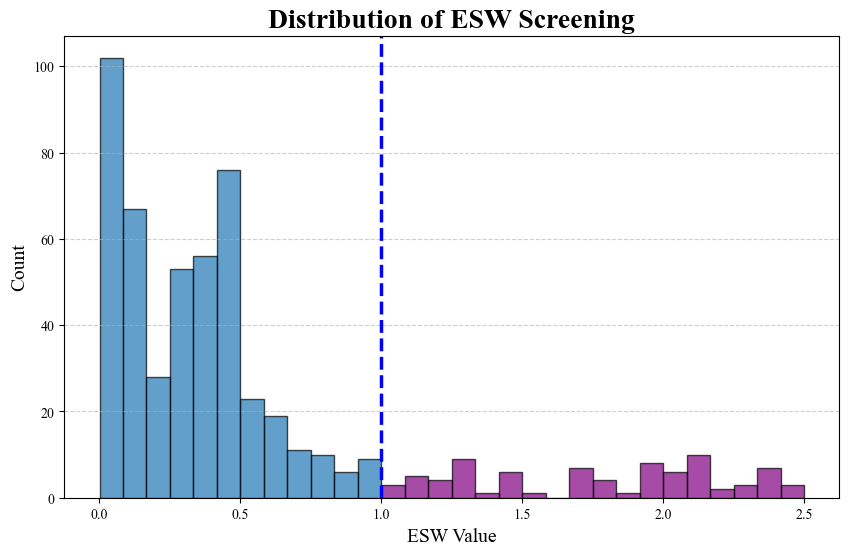

Number of ESW values greater than 1.0: 80


In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

with open('../Data/11_APs_ESW_results.json', 'r') as file:
    data = json.load(file)

esw_values = [entry['esw'] for entry in data]

count_above_1 = sum(1 for esw in esw_values if esw > 1.0)

plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(esw_values, bins=30, edgecolor='black', alpha=0.7)

plt.xlabel('ESW Value', fontname='Times New Roman', fontsize=14)
plt.ylabel('Count', fontname='Times New Roman', fontsize=14)
plt.title('Distribution of ESW Screening', fontname='Times New Roman', fontsize=20, fontweight='bold')
plt.xticks(fontname='Times New Roman')
plt.yticks(fontname='Times New Roman')

plt.axvline(x=1.0, color='blue', linestyle='--', linewidth=2.5)

for patch, bin_left in zip(patches, bins[:-1]):
    if bin_left >= 1.0:
        patch.set_facecolor('purple')

plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig('../Figure/ESW_distribution.png')
plt.show()

print(f"Number of ESW values greater than 1.0: {count_above_1}")

In [2]:
import json
import pandas as pd

# 加载ESW数据
with open('../Data/11_APs_ESW_results.json', 'r') as file:
    data = json.load(file)

# 筛选出ESW > 1.0的数据
filtered_data = [
    {'composition': entry['formula'], 'esw': entry['esw']}
    for entry in data
    if entry['esw'] > 1.0
]

# 将筛选后的数据转换为DataFrame，并按ESW从小到大排序
df = pd.DataFrame(filtered_data)
df = df.sort_values(by='esw', ascending=True)

# 保存为CSV文件
df.to_csv('../Data/12_APs_with_screened_ESW.csv', index=False)